In [1]:
"""# authenticate google drive
from google.colab import drive
drive.mount('/content/drive')
"""

"# authenticate google drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [2]:
# install necessary libraries
#!pip install pyrsgis

In [3]:
# import all the required libraries
import os, glob, re, time
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from copy import deepcopy
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Polygon

#os.chdir(r'/content/drive/My Drive/KathmanduUrbanGrowth/urban_growth_GWLR')
os.chdir(r'G:/My Drive/KathmanduUrbanGrowth/urban_growth_GWLR')

In [4]:
# define a function for alphanumeric filename sorting
def sorted_nicely(l): 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [5]:
# read dataframe
df = pd.read_csv('210803_Kathmandu_UGM_GWLR.zip', compression='zip')
#df.columns = [a.split('@')[0] for a in df.keys()]

# generate built-up layers
for year in [2000, 2010, 2020]:
  df['%d_built'%year] = (df['%d_landcover' % (year)] == 1).astype(int)

df['growth_00_10'] = df['2010_built'] - df['2000_built']
df['growth_10_20'] = df['2020_built'] - df['2010_built']

df = df[sorted_nicely(df.keys())]

print(df.keys())

Index(['2000_AD_K5', '2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9',
       '2000_BD_K11', '2000_BD_K13', '2000_VD_K5', '2000_built',
       '2000_dist_builtup', '2000_landcover', '2000_r1_dist', '2000_r2_dist',
       '2000_r3_dist', '2010_AD_K5', '2010_BD_K3', '2010_BD_K5', '2010_BD_K7',
       '2010_BD_K9', '2010_BD_K11', '2010_BD_K13', '2010_VD_K5', '2010_built',
       '2010_dist_builtup', '2010_landcover', '2010_r1_dist', '2010_r2_dist',
       '2010_r3_dist', '2020_AD_K5', '2020_BD_K3', '2020_BD_K5', '2020_BD_K7',
       '2020_BD_K9', '2020_BD_K11', '2020_BD_K13', '2020_VD_K5', '2020_built',
       '2020_dist_builtup', '2020_landcover', '2020_r1_dist', '2020_r2_dist',
       '2020_r3_dist', 'dist_bus_stops', 'dist_hospitals', 'dist_hotels',
       'dist_institutes', 'dist_water', 'elevation', 'growth_00_10',
       'growth_10_20', 'latitudes', 'longitudes', 'slope'],
      dtype='object')


## Create gdf for epoch 1

In [6]:
# create dataframe for epoch 1 
df_epoch1 = df[['2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9', '2000_BD_K11',
       '2000_BD_K13', '2000_built', '2000_VD_K5', '2000_AD_K5', '2000_dist_builtup',
       '2000_r1_dist', '2000_r2_dist', '2000_r3_dist', 'dist_bus_stops', 
       'dist_hospitals', 'dist_institutes', 'dist_hotels', 'dist_water', 'elevation', 
       'slope', 'growth_00_10', 'latitudes', 'longitudes']]

# extract non-builtup cells only and remove builtup column
df_epoch1 = df_epoch1.loc[df_epoch1['2000_built'] == 0]
df_epoch1.drop(['2000_built'], axis=1, inplace=True)

# create geodataframe for epoch 1
gdf_epoch1 = gpd.GeoDataFrame(df_epoch1, geometry=gpd.points_from_xy(df_epoch1.longitudes, df_epoch1.latitudes))
gdf_epoch1.crs = 'epsg:32645'

### Epoch 1 - create mesh for spatial sampling

319587.97 3051480.8 350037.97 3080610.8


<AxesSubplot:>

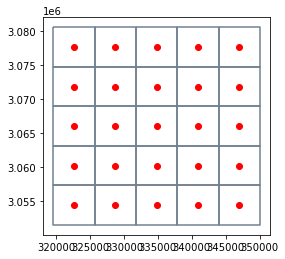

In [7]:
# spatial sampling using mesh
x_min, y_min, x_max, y_max = gdf_epoch1.total_bounds
print(x_min, y_min, x_max, y_max)

# using bounding box, determine the center of the grids for a n by m grid
X_SIZE = 5
Y_SIZE = 5

x_intervals = np.linspace(x_min, x_max, X_SIZE+1)
x_diff = np.diff(x_intervals)
x_centers = np.arange((x_min + x_diff[0]/2), (0.001 + x_max - x_diff[0]/2), x_diff[0])

y_intervals = np.linspace(y_min, y_max, Y_SIZE+1)
y_diff = np.diff(y_intervals)
y_centers = np.arange((y_min + y_diff[0]/2), (0.001 + y_max - y_diff[0]/2), y_diff[0])

# create points geodataframe
mesh_x_centers = np.meshgrid(x_centers, y_centers)[0].flatten()
mesh_y_centers = np.meshgrid(x_centers, y_centers)[1].flatten()
mesh_centroids = gpd.GeoDataFrame([], geometry=gpd.points_from_xy(mesh_x_centers, mesh_y_centers))

# define a function to create rectangular buffer
def rectangle_buffer(point, x_dist, y_dist):
    min_lon = point.x - x_dist
    max_lon = point.x + x_dist
    min_lat = point.y - y_dist
    max_lat = point.y + y_dist
    
    lon_list = [min_lon, max_lon, max_lon, min_lon, min_lon]
    lat_list = [max_lat, max_lat, min_lat, min_lat, max_lat]
    
    return Polygon(zip(lon_list, lat_list))

mesh_gdf = gpd.GeoDataFrame([], geometry=mesh_centroids.geometry.apply(
    lambda x: rectangle_buffer(x, x_diff[0]/2, y_diff[0]/2))
                               )

# Plot the results
fig, ax1 = plt.subplots()
mesh_centroids.plot(ax = ax1, color = 'red')
mesh_gdf.boundary.plot(ax=ax1, color = 'slategrey')

## Epoch 1 - check class balance in each strata

In [8]:
"""mesh_gdf['n_0'] = 0
mesh_gdf['n_1'] = 0

for index, row in mesh_gdf.iterrows():
    spatial_strata = gpd.clip(gdf_epoch1, row.geometry)
    n_1 = spatial_strata.loc[spatial_strata.growth_00_10==1].shape[0]
    
    mesh_gdf.loc[index, 'n_0'] = spatial_strata.shape[0] - n_1
    mesh_gdf.loc[index, 'n_1'] = n_1
    print('Number of 1s: %d. Number of 0s: %d' % (n_1, spatial_strata.shape[0] - n_1))

# plot the grid and export image
ax = mesh_gdf.geometry.boundary.plot(figsize=(7.5, 7.5))
mesh_gdf.apply(lambda x: ax.annotate(text='n_0=' + str(x['n_0']) + '\n\n' + 'n_1=' + str(x['n_1']), xy=x.geometry.centroid.coords[0], 
                                     ha='center', va='center'), axis=1)

# Export the figure
plt.savefig('./Images/%s_SpatialStrata_Epoch1_PT_V1.png' % (datetime.now().strftime('%y%m%d')), dpi=300, format='PNG', bbox_inches='tight', pad_inches = 0)
plt.close(fig)"""

"mesh_gdf['n_0'] = 0\nmesh_gdf['n_1'] = 0\n\nfor index, row in mesh_gdf.iterrows():\n    spatial_strata = gpd.clip(gdf_epoch1, row.geometry)\n    n_1 = spatial_strata.loc[spatial_strata.growth_00_10==1].shape[0]\n    \n    mesh_gdf.loc[index, 'n_0'] = spatial_strata.shape[0] - n_1\n    mesh_gdf.loc[index, 'n_1'] = n_1\n    print('Number of 1s: %d. Number of 0s: %d' % (n_1, spatial_strata.shape[0] - n_1))\n\n# plot the grid and export image\nax = mesh_gdf.geometry.boundary.plot(figsize=(7.5, 7.5))\nmesh_gdf.apply(lambda x: ax.annotate(text='n_0=' + str(x['n_0']) + '\n\n' + 'n_1=' + str(x['n_1']), xy=x.geometry.centroid.coords[0], \n                                     ha='center', va='center'), axis=1)\n\n# Export the figure\nplt.savefig('./Images/%s_SpatialStrata_Epoch1_PT_V1.png' % (datetime.now().strftime('%y%m%d')), dpi=300, format='PNG', bbox_inches='tight', pad_inches = 0)\nplt.close(fig)"

## Epoch1 - (down)sample data for each strata

In [9]:
EXPECTED_SAMPLE_SIZE = 3000
gdf_epoch1_sampled = gpd.GeoDataFrame()

for index, row in mesh_gdf.iterrows():
    spatial_strata = gpd.clip(gdf_epoch1, row.geometry)
    n_1 = spatial_strata.loc[spatial_strata.growth_00_10==1].shape[0]
    n_0 = spatial_strata.shape[0] - n_1

    # check if both classes are more than 500 and define sample size
    if (n_0 <= EXPECTED_SAMPLE_SIZE/2) or (n_1 <= EXPECTED_SAMPLE_SIZE/2):
        sample_size = min(n_0, n_1)
    else:
        sample_size = int(EXPECTED_SAMPLE_SIZE / 2)

    # perform random sampling
    growth = spatial_strata.loc[spatial_strata.growth_00_10==1]
    non_growth = spatial_strata.loc[spatial_strata.growth_00_10==0]
    print('Number of growth: %d, non_growth: %d' % (growth.shape[0], non_growth.shape[0]))

    growth = resample(growth,
                      replace = False, # sample without replacement
                      n_samples = sample_size, # match minority n
                      random_state = 2)

    non_growth = resample(non_growth,
                      replace = False, # sample without replacement
                      n_samples = sample_size, # match minority n
                      random_state = 2)
    print('Number of balanced growth: %d, non_growth: %d' % (growth.shape[0], non_growth.shape[0]))

    # Combine the balanced features
    spatial_strata = pd.concat([growth, non_growth], axis=0).pipe(gpd.GeoDataFrame)

    gdf_epoch1_sampled = pd.concat([gdf_epoch1_sampled, spatial_strata], axis=0).pipe(gpd.GeoDataFrame)
    
print('Epoch 1 - Number of sampled data points:', 
      gdf_epoch1_sampled.loc[gdf_epoch1_sampled.growth_00_10==0].shape, 
      gdf_epoch1_sampled.loc[gdf_epoch1_sampled.growth_00_10==1].shape
     )

Number of growth: 560, non_growth: 39191
Number of balanced growth: 560, non_growth: 560
Number of growth: 2342, non_growth: 36742
Number of balanced growth: 1500, non_growth: 1500
Number of growth: 3117, non_growth: 35536
Number of balanced growth: 1500, non_growth: 1500
Number of growth: 891, non_growth: 38809
Number of balanced growth: 891, non_growth: 891
Number of growth: 2, non_growth: 39773
Number of balanced growth: 2, non_growth: 2
Number of growth: 96, non_growth: 39460
Number of balanced growth: 96, non_growth: 96
Number of growth: 4250, non_growth: 33755
Number of balanced growth: 1500, non_growth: 1500
Number of growth: 8877, non_growth: 18993
Number of balanced growth: 1500, non_growth: 1500
Number of growth: 5173, non_growth: 32236
Number of balanced growth: 1500, non_growth: 1500
Number of growth: 1940, non_growth: 36190
Number of balanced growth: 1500, non_growth: 1500
Number of growth: 2058, non_growth: 36796
Number of balanced growth: 1500, non_growth: 1500
Number of

# Epoch 1 - check correlation of features in sampled data

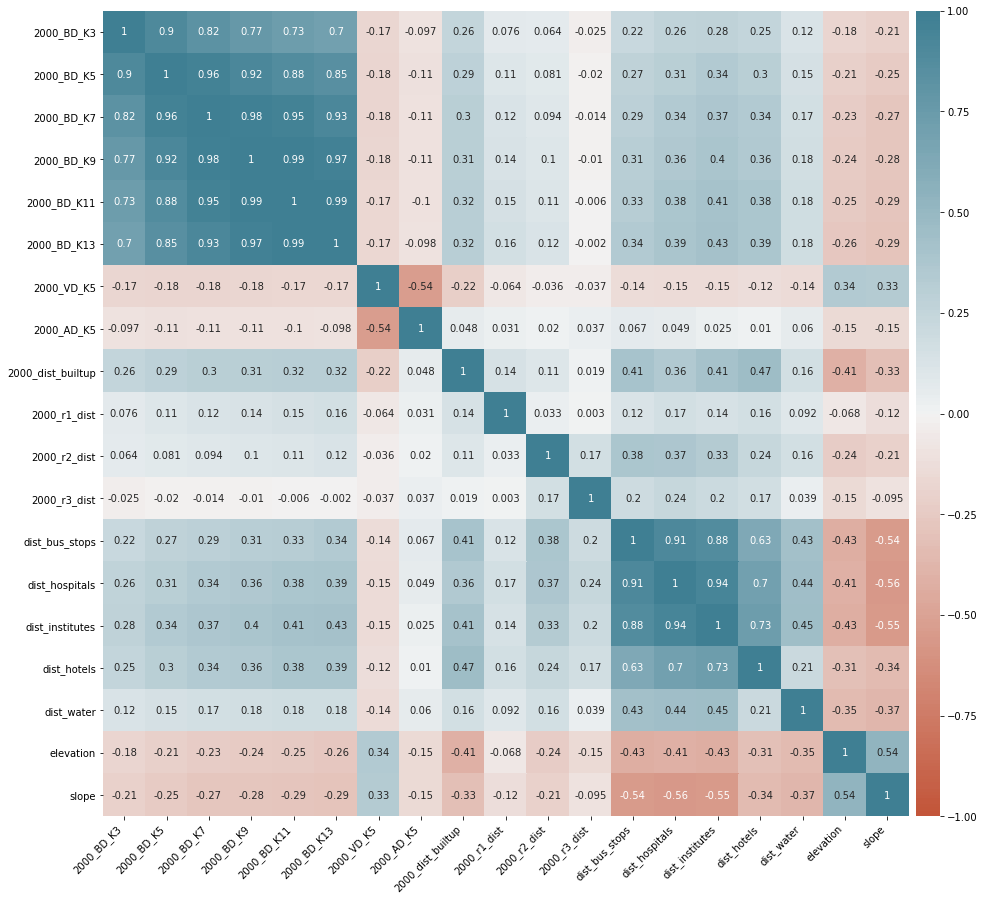

In [10]:
fig = None
ax = None

# get features only from the sampled geodataframe
gdf_epoch1_for_correlation = gdf_epoch1_sampled[
    [
    '2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9', '2000_BD_K11',
    '2000_BD_K13', '2000_VD_K5', '2000_AD_K5', '2000_dist_builtup',
    '2000_r1_dist', '2000_r2_dist', '2000_r3_dist', 'dist_bus_stops',
    'dist_hospitals', 'dist_institutes', 'dist_hotels', 'dist_water',
    'elevation', 'slope'
        ]
]

# plot correlation matrix for epoch 1
corr1 = gdf_epoch1_for_correlation.corr()
corr1 = np.round(corr1, 3)

# increase figure size
fig, ax = plt.subplots(figsize = (15, 15))

# adjust the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

sns.heatmap(
    ax=ax,
    data=corr1,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    cbar_ax = cax
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.savefig(r'./Images/%s_CorrMat_Epoch1_PT_V1.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)
plt.show()

## Epoch 1 - Remove unnecessary features and export the sampled shapefile

In [ ]:
corr1[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']].mean(axis=1).loc[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']]

In [12]:
gdf_epoch1_sampled.drop(['dist_bus_stops', 'dist_institutes'], axis=1).to_file(
    r'./shapefile/%s_Epoch1_SampledData_pt_utm45n_PT_V1.shp' % (datetime.now().strftime('%y%m%d'))
)

# Create gdf for epoch 2

In [13]:
# create dataframe for epoch 1 
df_epoch2 = df[['2010_BD_K3', '2010_BD_K5', '2010_BD_K7', '2010_BD_K9', '2010_BD_K11',
       '2010_BD_K13', '2010_built', '2010_VD_K5', '2010_AD_K5', '2010_dist_builtup',
       '2010_r1_dist', '2010_r2_dist', '2010_r3_dist', 'dist_bus_stops', 
       'dist_hospitals', 'dist_institutes', 'dist_hotels', 'dist_water', 'elevation', 
       'slope', 'growth_10_20', 'latitudes', 'longitudes']]

# extract non-builtup cells only and remove builtup column
df_epoch2 = df_epoch2.loc[df_epoch2['2010_built'] == 0]
df_epoch2.drop(['2010_built'], axis=1, inplace=True)

# create geodataframe for epoch 1
gdf_epoch2 = gpd.GeoDataFrame(df_epoch2, geometry=gpd.points_from_xy(df_epoch2.longitudes, df_epoch2.latitudes))
gdf_epoch2.crs = 'epsg:32645'

### Epoch 2 - create mesh for spatial sampling

319587.97 3051480.8 350037.97 3080610.8


<AxesSubplot:>

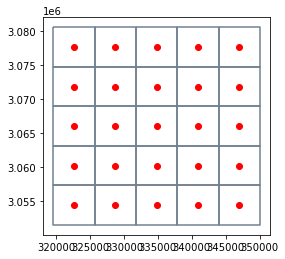

In [14]:
# spatial sampling using mesh
x_min, y_min, x_max, y_max = gdf_epoch2.total_bounds
print(x_min, y_min, x_max, y_max)

# using bounding box, determine the center of the grids for a n by m grid
X_SIZE = 5
Y_SIZE = 5

x_intervals = np.linspace(x_min, x_max, X_SIZE+1)
x_diff = np.diff(x_intervals)
x_centers = np.arange((x_min + x_diff[0]/2), (0.001 + x_max - x_diff[0]/2), x_diff[0])

y_intervals = np.linspace(y_min, y_max, Y_SIZE+1)
y_diff = np.diff(y_intervals)
y_centers = np.arange((y_min + y_diff[0]/2), (0.001 + y_max - y_diff[0]/2), y_diff[0])

# create points geodataframe
mesh_x_centers = np.meshgrid(x_centers, y_centers)[0].flatten()
mesh_y_centers = np.meshgrid(x_centers, y_centers)[1].flatten()
mesh_centroids = gpd.GeoDataFrame([], geometry=gpd.points_from_xy(mesh_x_centers, mesh_y_centers))

# define a function to create rectangular buffer
def rectangle_buffer(point, x_dist, y_dist):
    min_lon = point.x - x_dist
    max_lon = point.x + x_dist
    min_lat = point.y - y_dist
    max_lat = point.y + y_dist
    
    lon_list = [min_lon, max_lon, max_lon, min_lon, min_lon]
    lat_list = [max_lat, max_lat, min_lat, min_lat, max_lat]
    
    return Polygon(zip(lon_list, lat_list))

mesh_gdf = gpd.GeoDataFrame([], geometry=mesh_centroids.geometry.apply(
    lambda x: rectangle_buffer(x, x_diff[0]/2, y_diff[0]/2))
                               )

# Plot the results
fig, ax1 = plt.subplots()
mesh_centroids.plot(ax = ax1, color = 'red')
mesh_gdf.boundary.plot(ax=ax1, color = 'slategrey')

## Epoch 2 - check class balance in each strata

In [15]:
"""mesh_gdf['n_0'] = 0
mesh_gdf['n_1'] = 0

for index, row in mesh_gdf.iterrows():
    spatial_strata = gpd.clip(gdf_epoch2, row.geometry)
    n_1 = spatial_strata.loc[spatial_strata.growth_10_20==1].shape[0]
    
    mesh_gdf.loc[index, 'n_0'] = spatial_strata.shape[0] - n_1
    mesh_gdf.loc[index, 'n_1'] = n_1
    print('Number of 1s: %d. Number of 0s: %d' % (n_1, spatial_strata.shape[0] - n_1))

# plot the grid and export image
ax = mesh_gdf.geometry.boundary.plot(figsize=(7.5, 7.5))
mesh_gdf.apply(lambda x: ax.annotate(text='n_0=' + str(x['n_0']) + '\n\n' + 'n_1=' + str(x['n_1']), xy=x.geometry.centroid.coords[0], 
                                     ha='center', va='center'), axis=1)

# Export the figure
plt.savefig('./Images/%s_SpatialStrata_Epoch2_PT_V1.png' % (datetime.now().strftime('%y%m%d')), dpi=300, format='PNG', bbox_inches='tight', pad_inches = 0)
plt.close(fig)"""

"mesh_gdf['n_0'] = 0\nmesh_gdf['n_1'] = 0\n\nfor index, row in mesh_gdf.iterrows():\n    spatial_strata = gpd.clip(gdf_epoch2, row.geometry)\n    n_1 = spatial_strata.loc[spatial_strata.growth_10_20==1].shape[0]\n    \n    mesh_gdf.loc[index, 'n_0'] = spatial_strata.shape[0] - n_1\n    mesh_gdf.loc[index, 'n_1'] = n_1\n    print('Number of 1s: %d. Number of 0s: %d' % (n_1, spatial_strata.shape[0] - n_1))\n\n# plot the grid and export image\nax = mesh_gdf.geometry.boundary.plot(figsize=(7.5, 7.5))\nmesh_gdf.apply(lambda x: ax.annotate(text='n_0=' + str(x['n_0']) + '\n\n' + 'n_1=' + str(x['n_1']), xy=x.geometry.centroid.coords[0], \n                                     ha='center', va='center'), axis=1)\n\n# Export the figure\nplt.savefig('./Images/%s_SpatialStrata_Epoch2_PT_V1.png' % (datetime.now().strftime('%y%m%d')), dpi=300, format='PNG', bbox_inches='tight', pad_inches = 0)\nplt.close(fig)"

## Epoch2 - (down)sample data for each strata

In [16]:
EXPECTED_SAMPLE_SIZE = 3000
gdf_epoch2_sampled = gpd.GeoDataFrame()

for index, row in mesh_gdf.iterrows():
    spatial_strata = gpd.clip(gdf_epoch2, row.geometry)
    n_1 = spatial_strata.loc[spatial_strata.growth_10_20==1].shape[0]
    n_0 = spatial_strata.shape[0] - n_1

    # check if both classes are more than 500 and define sample size
    if (n_0 <= EXPECTED_SAMPLE_SIZE/2) or (n_1 <= EXPECTED_SAMPLE_SIZE/2):
        sample_size = min(n_0, n_1)
    else:
        sample_size = int(EXPECTED_SAMPLE_SIZE / 2)

    # perform random sampling
    growth = spatial_strata.loc[spatial_strata.growth_10_20==1]
    non_growth = spatial_strata.loc[spatial_strata.growth_10_20==0]
    print('Number of growth: %d, non_growth: %d' % (growth.shape[0], non_growth.shape[0]))

    growth = resample(growth,
                      replace = False, # sample without replacement
                      n_samples = sample_size, # match minority n
                      random_state = 2)

    non_growth = resample(non_growth,
                      replace = False, # sample without replacement
                      n_samples = sample_size, # match minority n
                      random_state = 2)
    print('Number of balanced growth: %d, non_growth: %d' % (growth.shape[0], non_growth.shape[0]))

    # Combine the balanced features
    spatial_strata = pd.concat([growth, non_growth], axis=0).pipe(gpd.GeoDataFrame)

    gdf_epoch2_sampled = pd.concat([gdf_epoch2_sampled, spatial_strata], axis=0).pipe(gpd.GeoDataFrame)
    
print('Epoch 2 - Number of sampled data points:', 
      gdf_epoch2_sampled.loc[gdf_epoch2_sampled.growth_10_20==0].shape, 
      gdf_epoch2_sampled.loc[gdf_epoch2_sampled.growth_10_20==1].shape
     )

Number of growth: 98, non_growth: 39093
Number of balanced growth: 98, non_growth: 98
Number of growth: 173, non_growth: 36569
Number of balanced growth: 173, non_growth: 173
Number of growth: 721, non_growth: 34815
Number of balanced growth: 721, non_growth: 721
Number of growth: 84, non_growth: 38725
Number of balanced growth: 84, non_growth: 84
Number of growth: 11, non_growth: 39762
Number of balanced growth: 11, non_growth: 11
Number of growth: 47, non_growth: 39413
Number of balanced growth: 47, non_growth: 47
Number of growth: 1179, non_growth: 32576
Number of balanced growth: 1179, non_growth: 1179
Number of growth: 5521, non_growth: 13472
Number of balanced growth: 1500, non_growth: 1500
Number of growth: 3227, non_growth: 29009
Number of balanced growth: 1500, non_growth: 1500
Number of growth: 1945, non_growth: 34245
Number of balanced growth: 1500, non_growth: 1500
Number of growth: 1368, non_growth: 35428
Number of balanced growth: 1368, non_growth: 1368
Number of growth: 

# Epoch 2 - check correlation of features in sampled data

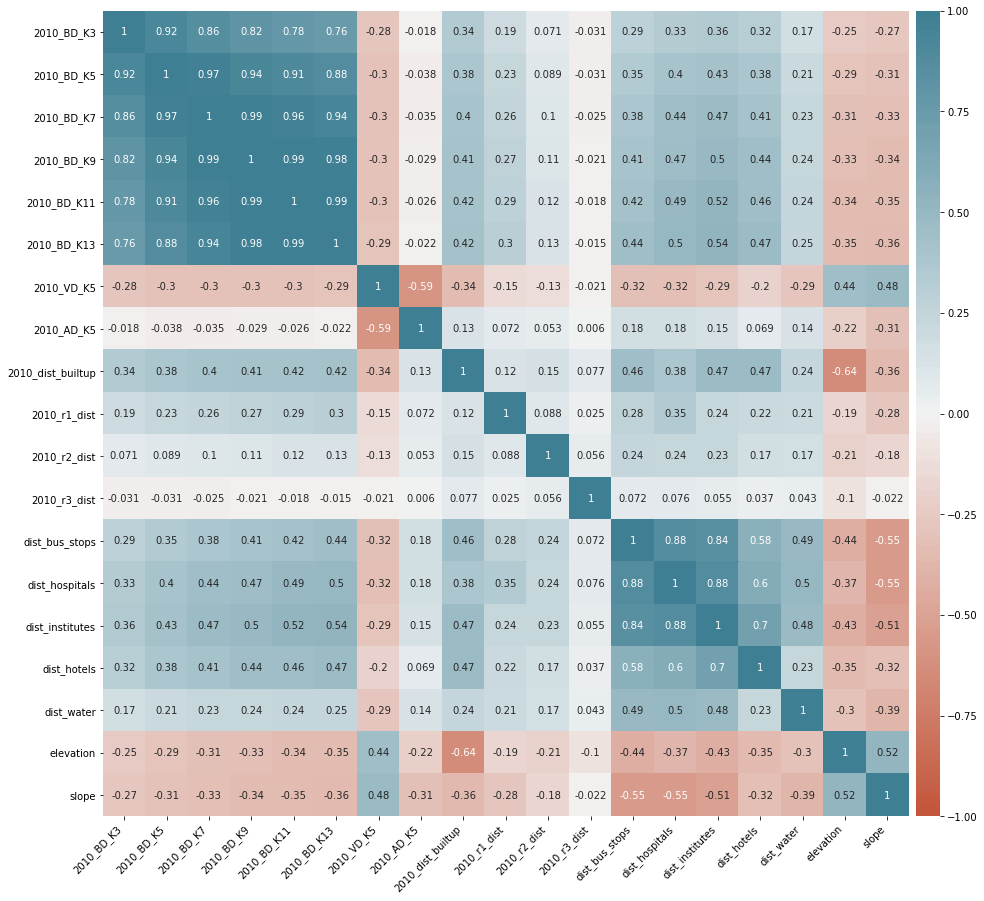

In [17]:
fig = None
ax = None

# get features only from the sampled geodataframe
gdf_epoch2_for_correlation = gdf_epoch2_sampled[
    [
    '2010_BD_K3', '2010_BD_K5', '2010_BD_K7', '2010_BD_K9', '2010_BD_K11',
    '2010_BD_K13', '2010_VD_K5', '2010_AD_K5', '2010_dist_builtup',
    '2010_r1_dist', '2010_r2_dist', '2010_r3_dist', 'dist_bus_stops',
    'dist_hospitals', 'dist_institutes', 'dist_hotels', 'dist_water',
    'elevation', 'slope'
        ]
]

# plot correlation matrix for epoch 1
corr2 = gdf_epoch2_for_correlation.corr()
corr2 = np.round(corr2, 3)

# increase figure size
fig, ax = plt.subplots(figsize = (15, 15))

# adjust the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

sns.heatmap(
    ax=ax,
    data=corr2,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    cbar_ax = cax
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.savefig(r'./Images/%s_CorrMat_Epoch2_PT_V1.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)
plt.show()

In [18]:
corr2[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']].mean(axis=1).loc[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']]

dist_bus_stops     0.904667
dist_hospitals     0.917667
dist_institutes    0.905667
dtype: float64

In [19]:
gdf_epoch2_sampled.drop(['dist_bus_stops', 'dist_institutes'], axis=1).to_file(
    r'./shapefile/%s_Epoch2_SampledData_pt_utm45n_PT_V1.shp' % (datetime.now().strftime('%y%m%d'))
)

## Old code below

## Check distribution of features

In [20]:
# reduce both the GDFs to DFs with covariates only
growth_00_10 = gdf_epoch1_sampled['growth_00_10']
df_epoch1_reduced = gdf_epoch1_sampled[[
    '2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9', '2000_BD_K11',
    '2000_BD_K13', '2000_VD_K5', '2000_AD_K5', '2000_dist_builtup',
    '2000_r1_dist', '2000_r2_dist', '2000_r3_dist',
    'dist_hospitals', 'dist_hotels', 'dist_water',
    'elevation', 'slope'
]]

growth_10_20 = gdf_epoch2_sampled['growth_10_20']
df_epoch2_reduced = gdf_epoch2_sampled[[
    '2010_BD_K3', '2010_BD_K5', '2010_BD_K7', '2010_BD_K9', '2010_BD_K11',
       '2010_BD_K13', '2010_VD_K5', '2010_AD_K5', '2010_dist_builtup',
       '2010_r1_dist', '2010_r2_dist', '2010_r3_dist',
       'dist_hospitals', 'dist_hotels', 'dist_water',
       'elevation', 'slope'
]]

# compute mean and standard deviation for both the epochs separately
mean_vals_e1 = df_epoch1_reduced.mean(axis=0)
std_vals_e1 = df_epoch1_reduced.std(axis=0)

mean_vals_e2 = df_epoch2_reduced.mean(axis=0)
std_vals_e2 = df_epoch2_reduced.std(axis=0)

# standarise data for both the epochs
for covariate in df_epoch1_reduced.keys():
    df_epoch1_reduced[covariate] = (df_epoch1_reduced[covariate] - mean_vals_e1[covariate]) / std_vals_e1[covariate]
    
for covariate in df_epoch2_reduced.keys():
    #print(covariate, round(mean_vals_e2[covariate], 3), round(std_vals_e2[covariate]))
    df_epoch2_reduced[covariate] = (df_epoch2_reduced[covariate] - mean_vals_e2[covariate]) / std_vals_e2[covariate]
    
df_epoch1_reduced.describe().round(decimals=2)

<ipython-input-20-ad619bcb153d>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch1_reduced[covariate] = (df_epoch1_reduced[covariate] - mean_vals_e1[covariate]) / std_vals_e1[covariate]
<ipython-input-20-ad619bcb153d>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch2_reduced[covariate] = (df_epoch2_reduced[covariate] - mean_vals_e2[covariate]) / std_vals_e2[covariate]


,2000_BD_K3,2000_BD_K5,2000_BD_K7,2000_BD_K9,2000_BD_K11,2000_BD_K13,2000_VD_K5,2000_AD_K5,2000_dist_builtup,2000_r1_dist,2000_r2_dist,2000_r3_dist,dist_hospitals,dist_hotels,dist_water,elevation,slope
count,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00,44632.00
mean,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.42,-0.48,-0.51,-0.53,-0.54,-0.55,-0.75,-0.71,-6.50,-5.50,-4.59,-3.34,-4.87,-5.40,-4.89,-2.88,-1.15
25%,-0.42,-0.48,-0.51,-0.53,-0.54,-0.55,-0.75,-0.71,-0.07,-0.29,-0.00,-0.10,-0.51,-0.47,-0.20,-0.51,-0.76
50%,-0.42,-0.48,-0.51,-0.44,-0.49,-0.47,-0.75,-0.71,0.40,0.27,0.37,0.45,0.32,0.23,0.34,-0.31,-0.36
75%,-0.42,0.08,0.05,0.05,0.06,0.07,0.79,0.81,0.56,0.61,0.53,0.58,0.76,0.75,0.61,0.17,0.50
max,6.33,6.24,6.13,6.06,6.00,5.91,2.01,2.75,0.61,0.84,0.62,0.63,1.11,1.27,0.82,6.07,6.06


In [21]:
df_epoch2_reduced.describe().round(decimals=2)

,2010_BD_K3,2010_BD_K5,2010_BD_K7,2010_BD_K9,2010_BD_K11,2010_BD_K13,2010_VD_K5,2010_AD_K5,2010_dist_builtup,2010_r1_dist,2010_r2_dist,2010_r3_dist,dist_hospitals,dist_hotels,dist_water,elevation,slope
count,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00,42718.00
mean,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.60,-0.68,-0.72,-0.75,-0.77,-0.79,-0.65,-0.90,-7.94,-5.25,-4.65,-3.52,-6.24,-5.69,-5.25,-2.86,-1.15
25%,-0.60,-0.68,-0.72,-0.75,-0.77,-0.79,-0.65,-0.90,-0.10,-0.33,-0.05,0.11,-0.47,-0.46,-0.23,-0.50,-0.75
50%,-0.60,-0.49,-0.54,-0.47,-0.44,-0.45,-0.65,-0.39,0.42,0.27,0.31,0.36,0.26,0.23,0.32,-0.32,-0.36
75%,0.54,0.45,0.39,0.47,0.48,0.47,0.66,0.89,0.56,0.69,0.52,0.46,0.75,0.74,0.63,0.09,0.52
max,3.97,3.84,3.75,3.69,3.64,3.59,2.09,2.29,0.56,0.97,0.64,0.51,1.23,1.35,0.85,6.51,5.73


In [22]:
# Use the following mean and std for scaling features for prediction
epoch2_mean_std = pd.concat([mean_vals_e2, std_vals_e2], axis=1)
epoch2_mean_std.columns = ['mean', 'sd']

print(epoch2_mean_std)
epoch2_mean_std.to_csv(r'./output/%s_Kathmandu_Epoch2_Mean_SD_PT_V1.csv' % (datetime.now().strftime('%y%m%d')))

                       mean        sd
2010_BD_K3         0.116264  0.194491
2010_BD_K5         0.144805  0.212290
2010_BD_K7         0.158619  0.218982
2010_BD_K9         0.167291  0.222573
2010_BD_K11        0.173482  0.225065
2010_BD_K13        0.178352  0.227080
2010_VD_K5         0.238177  0.364971
2010_AD_K5         0.282234  0.312791
2010_dist_builtup  0.945078  0.097322
2010_r1_dist       0.843328  0.160750
2010_r2_dist       0.878289  0.188812
2010_r3_dist       0.873977  0.248578
dist_hospitals     0.835843  0.133922
dist_hotels        0.808499  0.142107
dist_water         0.861001  0.164052
elevation          0.296650  0.103117
slope              0.148069  0.128220


## Grid search to find the best Lasso Logistic Model for both epochs

In [23]:
# perform the grid search to find the right parameters (lasso regression)
param_grid = [
    {'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
]

# set up grid search for the Epoch 1
logit_epoch1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)
grid_search_epoch1 = GridSearchCV(logit_epoch1, param_grid, cv=5, scoring='f1', n_jobs=-1)

# set up grid search for the Epoch 2
logit_epoch2 = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)
grid_search_epoch2 = GridSearchCV(logit_epoch2, param_grid, cv=5, scoring='f1', n_jobs=-1)

# run the grid search for both the epochs
grid_search_epoch1.fit(df_epoch1_reduced, growth_00_10)
grid_search_epoch2.fit(df_epoch2_reduced, growth_10_20)

# print the best params
lasso_c_epoch1 = grid_search_epoch1.best_params_['C']
lasso_c_epoch2 = grid_search_epoch2.best_params_['C']

print(lasso_c_epoch1)
print(lasso_c_epoch2)

1
1


In [24]:
# perform the grid search to find the right parameters (ridge regression)
param_grid = [
    {'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15]}
]

# set up grid search for the Epoch 1
logit_epoch1 = LogisticRegression(penalty='l2', random_state=0)
grid_search_epoch1 = GridSearchCV(logit_epoch1, param_grid, cv=5, scoring='f1', n_jobs=-1)

# set up grid search for the Epoch 2
logit_epoch2 = LogisticRegression(penalty='l2', random_state=0)
grid_search_epoch2 = GridSearchCV(logit_epoch2, param_grid, cv=5, scoring='f1', n_jobs=-1)

# run the grid search for both the epochs
grid_search_epoch1.fit(df_epoch1_reduced, growth_00_10)
grid_search_epoch2.fit(df_epoch2_reduced, growth_10_20)

# print the best params
ridge_c_epoch1 = grid_search_epoch1.best_params_['C']
ridge_c_epoch2 = grid_search_epoch2.best_params_['C']

print(ridge_c_epoch1)
print(ridge_c_epoch2)

2
8


# Feature Selection Using Lasso Regression

In [25]:
# perform feature selection using Lasso Model for epoch 1
sel_e1 = SelectFromModel(LogisticRegression(C=lasso_c_epoch1, penalty='l1', solver='liblinear'))
sel_e1.fit(df_epoch1_reduced, growth_00_10)
selected_feat_e1 = df_epoch1_reduced.columns[(sel_e1.get_support())]

print('Total features for Epoch 1: {}'.format((df_epoch1_reduced.shape[1])))
print('Selected features for Epoch 1: {}'.format(len(selected_feat_e1)))

sel_e2 = SelectFromModel(LogisticRegression(C=lasso_c_epoch2, penalty='l1', solver='liblinear'))
sel_e2.fit(df_epoch2_reduced, growth_10_20)
selected_feat_e2 = df_epoch2_reduced.columns[(sel_e2.get_support())]

print('Total features for Epoch 2: {}'.format((df_epoch1_reduced.shape[1])))
print('Selected features for Epoch 2: {}'.format(len(selected_feat_e1)))

lasso_importances_e1 = pd.Series(sel_e1.estimator_.coef_.flatten(), index=df_epoch1_reduced.columns)
lasso_importances_e2 = pd.Series(sel_e2.estimator_.coef_.flatten(), index=df_epoch2_reduced.columns)

Total features for Epoch 1: 17
Selected features for Epoch 1: 17
Total features for Epoch 2: 17
Selected features for Epoch 2: 17


In [41]:
# Epoch 1 - loop through feature importance arranged in ascending order
abs_importance_e1 = np.abs(lasso_importances_e1)

pscore_dict_e1 = dict()
rscore_dict_e1 = dict()
fscore_dict_e1 = dict()

for covariate in abs_importance_e1.sort_values(ascending=True).index:
    filtered_series = abs_importance_e1.loc[abs_importance_e1 >= abs_importance_e1[covariate]]
    
    print('\nRetaining %d features:' % (filtered_series.shape[0]))
    print('Dropping', abs_importance_e1.loc[abs_importance_e1 < abs_importance_e1[covariate]].index.values)
    #print(filtered_series)
    
    # K-Fold cross validation of logit model
    sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    #x_e1, y_e1 = df_epoch1_reduced[filtered_series.index].to_numpy(), growth_00_10.to_numpy()
    
    growth_00_10 = gdf_epoch1['growth_00_10']
    x_e1, y_e1 = gdf_epoch1[filtered_series.index].to_numpy(), growth_00_10.to_numpy()
    
    p_score_list = []
    r_score_list = []
    f1_score_list = []

    n = 1
    for train_index, test_index in sk_fold.split(x_e1, y_e1):
        #print('\nEvaluating fold number', n)
        x_train, x_test = x_e1[train_index], x_e1[test_index]
        y_train, y_test = y_e1[train_index], y_e1[test_index]

        #lr_e1 = LogisticRegression(C=ridge_c_epoch1, penalty='l2', n_jobs=-1)
        lr_e1 = LogisticRegression(penalty='l2', n_jobs=-1)
        lr_e1.fit(x_train, y_train)

        y_pred = lr_e1.predict(x_test)
        c_matrix = confusion_matrix(y_test, y_pred)
        p_score = precision_score(y_test, y_pred)
        r_score = recall_score(y_test, y_pred)
        f_score = f1_score(y_test, y_pred)

        #print('Confusion matrix:\n', c_matrix)
        #print('F1-Score:', f_score)

        p_score_list.append(p_score)
        r_score_list.append(r_score)
        f1_score_list.append(f_score)

        n += 1

    print('Precision, Recall and F1 Score:', np.mean(p_score_list), np.mean(r_score_list), np.mean(f1_score_list))
    
    pscore_dict_e1[filtered_series.shape[0]] = np.mean(p_score_list)
    rscore_dict_e1[filtered_series.shape[0]] = np.mean(r_score_list)
    fscore_dict_e1[filtered_series.shape[0]] = np.mean(f1_score_list)


Retaining 17 features:
Dropping []
Precision, Recall and F1 Score: 0.7124053642834683 0.3005572494034508 0.422746567757229

Retaining 16 features:
Dropping ['2000_r2_dist']
Precision, Recall and F1 Score: 0.7125205108496007 0.30014607584756187 0.42235784201352206

Retaining 15 features:
Dropping ['2000_BD_K7' '2000_r2_dist']


KeyboardInterrupt: 

In [27]:
# Epoch 2 - loop through feature importance arranged in ascending order
abs_importance_e2 = np.abs(lasso_importances_e2)

pscore_dict_e2 = dict()
rscore_dict_e2 = dict()
fscore_dict_e2 = dict()

for covariate in abs_importance_e2.sort_values(ascending=True).index:
    filtered_series = abs_importance_e2.loc[abs_importance_e2 >= abs_importance_e2[covariate]]
    
    print('\nRetaining %d features:' % (filtered_series.shape[0]))
    print('Dropping', abs_importance_e2.loc[abs_importance_e2 < abs_importance_e2[covariate]].index.values)
    #print(filtered_series)
    
    # K-Fold cross validation of logit model
    sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    x_e2, y_e2 = df_epoch2_reduced[filtered_series.index].to_numpy(), growth_10_20.to_numpy()

    p_score_list = []
    r_score_list = []
    f1_score_list = []

    n = 1
    for train_index, test_index in sk_fold.split(x_e2, y_e2):
        #print('\nEvaluating fold number', n)
        x_train, x_test = x_e2[train_index], x_e2[test_index]
        y_train, y_test = y_e2[train_index], y_e2[test_index]

        lr_e2 = LogisticRegression(C=ridge_c_epoch2, penalty='l2', n_jobs=-1)
        lr_e2.fit(x_train, y_train)

        y_pred = lr_e2.predict(x_test)
        c_matrix = confusion_matrix(y_test, y_pred)
        p_score = precision_score(y_test, y_pred)
        r_score = recall_score(y_test, y_pred)
        f_score = f1_score(y_test, y_pred)

        #print('Confusion matrix:\n', c_matrix)
        #print('F1-Score:', f_score)

        p_score_list.append(p_score)
        r_score_list.append(r_score)
        f1_score_list.append(f_score)

        n += 1

    print('Precision, Recall and F1 Score:', np.mean(p_score_list), np.mean(r_score_list), np.mean(f1_score_list))
    
    pscore_dict_e2[filtered_series.shape[0]] = np.mean(p_score_list)
    rscore_dict_e2[filtered_series.shape[0]] = np.mean(r_score_list)
    fscore_dict_e2[filtered_series.shape[0]] = np.mean(f1_score_list)


Retaining 17 features:
Dropping []
Precision, Recall and F1 Score: 0.6485695482676949 0.761364609942325 0.700413958980087

Retaining 16 features:
Dropping ['2010_r2_dist']
Precision, Recall and F1 Score: 0.6484727796337852 0.7614582538626061 0.7003962645043795

Retaining 15 features:
Dropping ['2010_r1_dist' '2010_r2_dist']
Precision, Recall and F1 Score: 0.6483315290547157 0.7614581223248509 0.700310855388506

Retaining 14 features:
Dropping ['2010_r1_dist' '2010_r2_dist' '2010_r3_dist']
Precision, Recall and F1 Score: 0.6479905563824067 0.7622539586287452 0.7004462649780311

Retaining 13 features:
Dropping ['2010_r1_dist' '2010_r2_dist' '2010_r3_dist' 'dist_hotels']
Precision, Recall and F1 Score: 0.6468682294873694 0.7603344172044368 0.6989769045721774

Retaining 12 features:
Dropping ['2010_r1_dist' '2010_r2_dist' '2010_r3_dist' 'dist_hotels' 'dist_water']
Precision, Recall and F1 Score: 0.6466739075370301 0.7604749214500371 0.6989338140589039

Retaining 11 features:
Dropping ['20

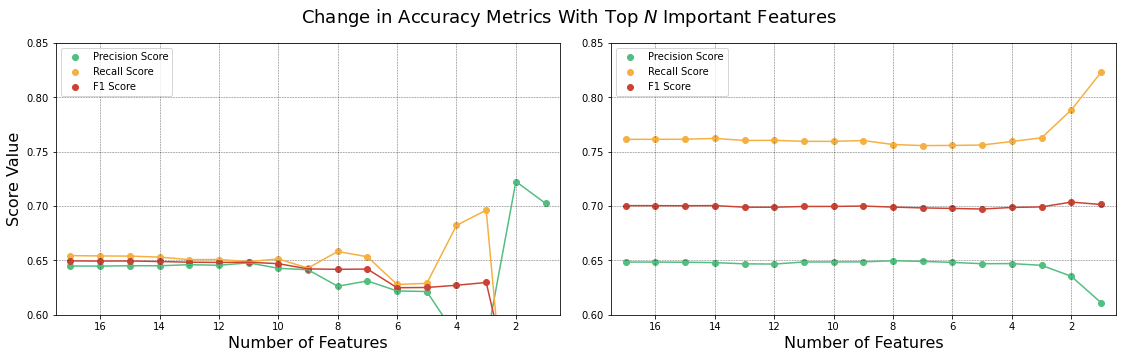

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (19, 5))

# plot points for Epoch 1
ax[0].scatter(x=list(pscore_dict_e1.keys()), y=list(pscore_dict_e1.values()),
          color='#52BE80', label='Precision Score')
ax[0].plot(list(pscore_dict_e1.keys()), list(pscore_dict_e1.values()), color='#52BE80')

ax[0].scatter(x=list(rscore_dict_e1.keys()), y=list(rscore_dict_e1.values()),
          color='#F5B041', label='Recall Score')
ax[0].plot(list(rscore_dict_e1.keys()), list(rscore_dict_e1.values()), color='#F5B041')

ax[0].scatter(x=list(fscore_dict_e1.keys()), y=list(fscore_dict_e1.values()),
          color='#CB4335', label='F1 Score')
ax[0].plot(list(fscore_dict_e1.keys()), list(fscore_dict_e1.values()), color='#CB4335')

#pscore_dict_e2 = {key:pscore_dict_e2[key] for key in sorted(pscore_dict_e2, reverse=True)}

# plot points for Epoch 2
ax[1].scatter(x=list(pscore_dict_e2.keys()), y=list(pscore_dict_e2.values()),
          color='#52BE80', label='Precision Score')
ax[1].plot(list(pscore_dict_e2.keys()), list(pscore_dict_e2.values()), color='#52BE80')

ax[1].scatter(x=list(rscore_dict_e2.keys()), y=list(rscore_dict_e2.values()),
          color='#F5B041', label='Recall Score')
ax[1].plot(list(rscore_dict_e2.keys()), list(rscore_dict_e2.values()), color='#F5B041')

ax[1].scatter(x=list(fscore_dict_e2.keys()), y=list(fscore_dict_e2.values()),
          color='#CB4335', label='F1 Score')
ax[1].plot(list(fscore_dict_e2.keys()), list(fscore_dict_e2.values()), color='#CB4335')


# reverse the plots
for n in range(0, 2):
    ax[n].set_xlim(17.5, 0.5)
    ax[n].set_ylim(0.6, 0.85)

    ax[n].grid(color='black', linestyle='--', linewidth=0.5, which='minor', alpha=0.6)
    ax[n].grid(color='black', linestyle='--', linewidth=0.5, which='major', alpha=0.6)
    
    ax[n].set_xlabel("Number of Features", fontsize=16)

    ax[n].legend(loc='upper left')

ax[0].set_ylabel("Score Value", fontsize=16)
    
fig.subplots_adjust(wspace=0.1, hspace=0)
plt.suptitle('Change in Accuracy Metrics With Top $\it{N}$ Important Features', fontsize=18)
plt.rc('legend', fontsize=14)

plt.savefig(r'Images/%s_NFeatures_Accuracies_5Fold_PT_V1.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)

In [29]:
# print the covariates in descending order of coef to find the value to draw line in the feature importance graph
print(abs_importance_e2.sort_values(ascending=False))

2010_VD_K5           0.686114
slope                0.391753
2010_BD_K13          0.363715
2010_BD_K11          0.226354
2010_BD_K7           0.204940
2010_BD_K5           0.154180
dist_hospitals       0.145277
2010_dist_builtup    0.105849
elevation            0.104842
2010_BD_K3           0.094153
2010_BD_K9           0.085984
2010_AD_K5           0.067347
dist_water           0.063323
dist_hotels          0.050216
2010_r3_dist         0.044750
2010_r1_dist         0.026702
2010_r2_dist         0.003102
dtype: float64


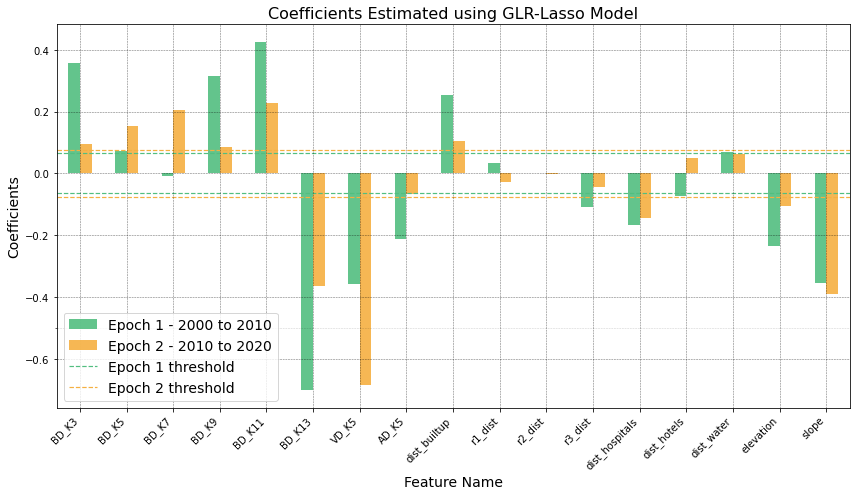

In [30]:
#std_epoch1 = np.std([tree.feature_importances_ for tree in lr_epoch1.estimators_], axis=0)
lasso_importances_e1_plot = deepcopy(lasso_importances_e1)
lasso_importances_e1_plot.index = lasso_importances_e1.index.str.replace('2000_', '')

#std_epoch2 = np.std([tree.feature_importances_ for tree in lr_epoch2.estimators_], axis=0)
lasso_importances_e2_plot = deepcopy(lasso_importances_e2)
lasso_importances_e2_plot.index = lasso_importances_e2.index.str.replace('2010_', '')

fig, ax = plt.subplots(figsize = (12, 7))

#importance_df = pd.concat([lr_importances_epoch1.abs(), lr_importances_epoch2.abs()], axis=1)
importance_df = pd.concat([lasso_importances_e1_plot, lasso_importances_e2_plot], axis=1)
importance_df.columns = ['Epoch 1 - 2000 to 2010', 'Epoch 2 - 2010 to 2020']

importance_df.plot.bar(ax=ax, y=["Epoch 1 - 2000 to 2010", "Epoch 2 - 2010 to 2020"], 
                       color={"Epoch 1 - 2000 to 2010":'#52BE80', "Epoch 2 - 2010 to 2020":'#F5B041'}, alpha=0.9)

# add threshold line for epoch 1 and 2
ax.axhline(y=0.065, c="#52BE80", linestyle='--', linewidth=1.2, zorder=1, label='Epoch 1 threshold')
ax.axhline(y=-0.065, c="#52BE80", linestyle='--', linewidth=1.2, zorder=1)
ax.axhline(y=0.075, c="#F5B041", linestyle='--', linewidth=1.2, zorder=1, label='Epoch 2 threshold')
ax.axhline(y=-0.075, c="#F5B041", linestyle='--', linewidth=1.2, zorder=1)

ax.set_title("Coefficients Estimated using GLR-Lasso Model", fontsize=16)
ax.set_ylabel("Coefficients", fontsize=14)
ax.set_xlabel("Feature Name", fontsize=14)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
# reorder legend entries
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 3, 0, 1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc='lower left')
plt.rc('legend', fontsize=12)

ax.grid(color='black', linestyle='--', linewidth=0.5, which='minor', alpha=0.2)
ax.grid(color='black', linestyle='--', linewidth=0.5, which='major', alpha=0.6)
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
#ax.xaxis.grid(False)

plt.savefig(r'./Images/%s_GLR-Lasso_FeatImportance_BothEpochs_PT_V1.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)
fig.tight_layout()

## Remove less important features, add lat and lon columns, export CSV

In [31]:
GLLR_coef = pd.concat([pd.Series(lasso_importances_e1_plot.index, index=lasso_importances_e1_plot.index), lasso_importances_e1_plot, lasso_importances_e2_plot], axis=1)
GLLR_coef.columns = ['FeatureName', 'Epoch1', 'Epoch2']

print(GLLR_coef)

                   FeatureName    Epoch1    Epoch2
BD_K3                    BD_K3  0.355618  0.094153
BD_K5                    BD_K5  0.071309  0.154180
BD_K7                    BD_K7 -0.008572  0.204940
BD_K9                    BD_K9  0.315672  0.085984
BD_K11                  BD_K11  0.425591  0.226354
BD_K13                  BD_K13 -0.702218 -0.363715
VD_K5                    VD_K5 -0.359121 -0.686114
AD_K5                    AD_K5 -0.213585 -0.067347
dist_builtup      dist_builtup  0.252880  0.105849
r1_dist                r1_dist  0.032585 -0.026702
r2_dist                r2_dist  0.001022 -0.003102
r3_dist                r3_dist -0.108912 -0.044750
dist_hospitals  dist_hospitals -0.165782 -0.145277
dist_hotels        dist_hotels -0.074725  0.050216
dist_water          dist_water  0.068015  0.063323
elevation            elevation -0.236032 -0.104842
slope                    slope -0.354065 -0.391753


In [32]:
selected_epoch1_columns = abs_importance_e1.sort_values(ascending=False).head(13)
#print(selected_epoch1_columns)

selected_export_epoch1 = df_epoch1_reduced[selected_epoch1_columns.keys()]
selected_export_epoch1[['latitudes', 'longitudes', 'growth_00_10']] = df.loc[selected_export_epoch1.index, 
                                                                             ['latitudes', 'longitudes', 'growth_00_10']]

print(selected_export_epoch1.head())

        2000_BD_K13  2000_BD_K11  2000_VD_K5  2000_BD_K3     slope  \
978432    -0.548849    -0.539631    0.903457   -0.416547  1.015071   
970294    -0.548849    -0.539631   -0.749508   -0.416547  1.615400   
927662    -0.548849    -0.539631   -0.749508   -0.416547  2.215561   
923570    -0.548849    -0.539631   -0.749508   -0.416547  1.631037   
937791    -0.548849    -0.539631    1.013654   -0.416547  1.273295   

        2000_BD_K9  2000_dist_builtup  elevation  2000_AD_K5  dist_hospitals  \
978432   -0.526487          -3.987774  -0.716981   -0.714815       -3.642942   
970294   -0.526487          -3.778659  -0.543511   -0.021728       -3.633391   
927662   -0.526487          -0.955618   2.967938   -0.714815       -3.064316   
923570   -0.526487          -1.373846   1.333117    0.116889       -3.194157   
937791   -0.526487          -2.053467   1.979686   -0.714815       -3.323258   

        2000_r3_dist  dist_hotels  2000_BD_K5  latitudes  longitudes  \
978432      0.393364    -3

C:\Users\gsl\Anaconda3\envs\prat_env\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [33]:
selected_epoch2_columns = abs_importance_e2.sort_values(ascending=False).head(12)
#print(selected_epoch2_columns)

selected_export_epoch2 = df_epoch2_reduced[selected_epoch2_columns.keys()]
selected_export_epoch2[['latitudes', 'longitudes', 'growth_10_20']] = df.loc[selected_export_epoch2.index, 
                                                                             ['latitudes', 'longitudes', 'growth_10_20']]

print(selected_export_epoch2.head())

        2010_VD_K5     slope  2010_BD_K13  2010_BD_K11  2010_BD_K7  \
971325   -0.652591  1.679951     0.309006     0.257361    0.021216   
960124   -0.652591 -0.768912    -0.576953    -0.513766   -0.351565   
978440   -0.652591 -0.469156     0.569582     0.734726    1.232757   
934720   -0.652591  3.080309    -0.681183    -0.623927   -0.537956   
887019   -0.652591  4.650329    -0.550895    -0.440325   -0.444761   

        2010_BD_K5  dist_hospitals  2010_dist_builtup  elevation  2010_BD_K3  \
971325   -0.116847       -4.605131           0.564333  -0.786489   -0.026493   
960124   -0.116847       -4.672378           0.564333  -0.599296   -0.026493   
978440    1.578943       -4.657529           0.564333  -0.874887    1.687384   
934720   -0.493689       -4.457937           0.490412  -0.219708   -0.597786   
887019   -0.305268       -3.606932           0.490412   0.903454   -0.597786   

        2010_BD_K9  2010_AD_K5  latitudes  longitudes  growth_10_20  
971325    0.024928   -0.9023

C:\Users\gsl\Anaconda3\envs\prat_env\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [34]:
selected_export_epoch1.to_csv('%s_Kathmandu_Epoch1_FeatureReduced_PT_V1.csv' % (datetime.now().strftime('%y%m%d')), index=False)
selected_export_epoch2.to_csv('%s_Kathmandu_Epoch2_FeatureReduced_PT_V1.csv' % (datetime.now().strftime('%y%m%d')), index=False)
GLLR_coef.to_csv('%s_Kathmandu_GLR-Lasso_Coef_PT_V1.csv' % (datetime.now().strftime('%y%m%d')), index=False)